In [38]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn

2586.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2593.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2600.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2607.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from tqdm import tqdm
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

plt.rcParams['text.usetex'] = False

In [37]:
def unfuck(prediction):
    fucked_index = prediction.find("}")
    if fucked_index >= 0:
        try:
            json_data = json.loads(prediction[0:fucked_index+1])
            unfucked_tags = json_data['tags']
            return False, unfucked_tags
        except Exception as fuckedup:
            return True, None
    else:
        return True, None
    
    return fucked

song_ids = []
with open('data/all_songs.json', 'rt', encoding='utf8') as infile:
    songs = json.load(infile)
    for song in songs:
        song_ids.append(song['GeniusId'])

with open('predictions_evaluation.json', 'rt', encoding='utf8') as infile:
    unfucked_songs = []
    songs = json.load(infile) 
    songs_len = len(songs)
    for song in tqdm(songs, total=songs_len):
        if(song['GeniusId'] in song_ids or not song['Lyrics']):
            continue

        if('PredictedTags' not in song or song['PredictedTags'] == None):
            song['WasFucked'] = True
            is_fucked, tags = unfuck(song['RawPrediction'])
            if is_fucked:
                song['IsFucked'] = True 
            else:
                song['IsFucked'] = False
                song['PredictedTags'] = tags
        else:
            song['WasFucked'] = True
            song['IsFucked'] = False
        
        unfucked_songs.append(song)

    with open('predictions_evaluation_unfucked.json', 'wt', encoding='utf8') as outfile:
        json.dump(unfucked_songs, outfile, indent=2)

100%|██████████| 25000/25000 [00:09<00:00, 2655.66it/s]


In [92]:
tag_alias = json.load(open('tag_alias.json'))
tag_lookup = {alias: tag for tag, aliases in tag_alias.items() for alias in aliases}
print(tag_lookup)

with open('predictions_evaluation_unfucked.json', 'rt', encoding='utf8') as infile:
    songs = json.load(infile)
    for song in tqdm(songs):
        song['LastFMTags'] = list(set([tag_lookup[x] if x in tag_lookup else x for x in song['LastFMTags']]))
        song['PredictedTags'] = list(set([tag_lookup[x] if x in tag_lookup else x for x in song ['PredictedTags']]))

    with open('predictions_evaluation_unfucked_cleaned-tags.json', 'wt', encoding='utf8') as outfile:
        json.dump(songs, outfile, indent=2)

{'pop': 'pop', 'pop music': 'pop', 'azerbaijan': 'azerbaijan', 'azeri': 'azerbaijan', 'dominican republic': 'dominican', 'dominican': 'dominican', 'deutsch': 'german', 'german': 'german', 'german lyrics': 'german', 'melancholy': 'melancholic', 'melancholic': 'melancholic', '-melancholic-': 'melancholic', 'melancolica': 'melancholic', 'indie india': 'idian-indie', 'indian indie': 'idian-indie', 'christmas': 'christmas', 'xmas': 'christmas', 'christmas tag': 'christmas', 'nepal': 'nepal', 'nepali': 'nepal', 'folk pop': 'folk pop', 'pop-folk': 'folk pop', 'folkpop': 'folk pop', 'colombia': 'colombia', 'colombian': 'colombia', 'r and b': 'rhythm and blues', 'r&amp;b': 'rhythm and blues', 'rhythm and blues': 'rhythm and blues', 'rb': 'rhythm and blues', 'rnb': 'rhythm and blues', 'brasil': 'brasil', 'brazilian': 'brasil', 'brazil': 'brasil', 'pop-rap': 'pop rap', 'pop rap': 'pop rap', 'death metal': 'death metal', '-death metal-': 'death metal', 'trash metal': 'thrash metal', 'thrash metal'

100%|██████████| 23256/23256 [00:00<00:00, 163540.75it/s]


In [93]:
tag_alias = json.load(open('tag_alias.json'))  
tags = pd.read_csv('tags_manual_removal.csv', index_col='Tag')
curated_tags = list(set([tag_lookup[x] if x in tag_lookup else x for x, _ in tags.iterrows()]))
with open('curated_tags.json', 'wt', encoding='utf8') as outfile:
    json.dump(curated_tags, outfile, indent=2)

In [94]:
curated_tags = json.load(open('curated_tags.json'))
data = pd.read_json('predictions_evaluation_unfucked_cleaned-tags.json', orient='records')
data.set_index('GeniusId', inplace=True)
data.info()

def get_counts(name):
    tag_counts = data[name].explode().value_counts().reset_index()
    tag_counts.columns = ['Tag', 'Count']
    tag_counts.set_index('Tag', inplace=True)
    tag_counts = tag_counts.loc[tag_counts.index.intersection(curated_tags)]
    tag_counts.info()
    return tag_counts


get_counts('LastFMTags').to_csv('tag_counts_actual.csv')
get_counts('PredictedTags').to_csv('tag_counts_predicted.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 23256 entries, 1046647 to 1821834
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ArtistId           23256 non-null  int64 
 1   PrimaryArtistName  23256 non-null  object
 2   FeaturedArtists    23256 non-null  object
 3   Title              23256 non-null  object
 4   Lyrics             23256 non-null  object
 5   ArtistNames        23256 non-null  object
 6   HasCompleteLyrics  23256 non-null  bool  
 7   LastFMTags         23256 non-null  object
 8   RawPrediction      23256 non-null  object
 9   PredictedTags      23256 non-null  object
 10  WasFucked          23256 non-null  bool  
 11  IsFucked           23256 non-null  bool  
dtypes: bool(3), int64(1), object(8)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, hip-hop to gabber
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  -------------- 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


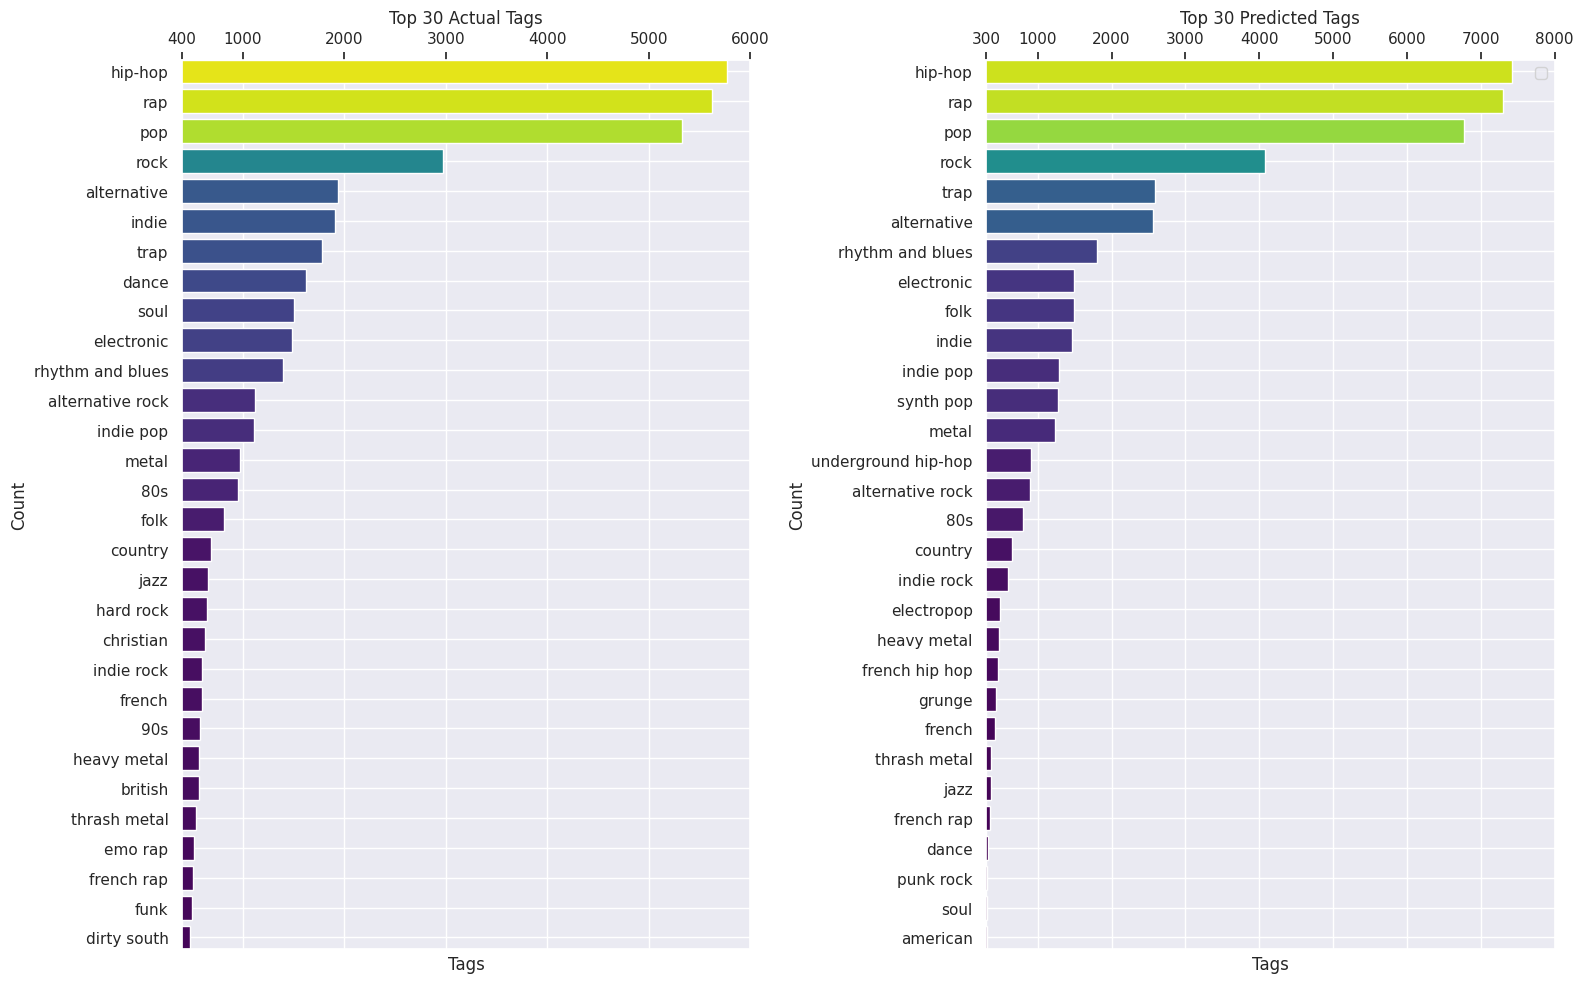

In [100]:
sns.set_theme(style='whitegrid')
sns.set_color_codes('pastel')
sns.set()
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(16)

def render_counts(title, tags, ax, top_n):
    cmap = plt.get_cmap('viridis')
    to_show = tags.sort_values(by=['Count'], ascending=False).head(top_n).sort_values(by=['Count'], ascending=True)
    rounded_max = (np.ceil(to_show.Count.max() / 1000) * 1000)
    rounded_min = (np.floor(to_show.Count.min() / 100) * 100)
    rounded_min_thousand = (np.ceil(to_show.Count.min() / 1000) * 1000)

    rescale = lambda y: (y - rounded_min) / (rounded_max - rounded_min)
    ax.barh(to_show.index, to_show['Count'], color=cmap(rescale(to_show.Count)))
    ax.set_title(f'Top {top_n} {title}')
    ax.set_xlabel('Tags')
    ax.set_ylabel('Count')
    ax.set_xlim(rounded_min, rounded_max)

    ticks = np.arange(rounded_min_thousand, rounded_max + 1, 1000)
    ticks = np.insert(ticks, 0, rounded_min)

    ax.set_xticks(ticks)
    ax.xaxis.tick_top()
    ax.margins(0,0)


tags_actual = pd.read_csv('tag_counts_actual.csv', index_col='Tag')
tags_predicted = pd.read_csv('tag_counts_predicted.csv', index_col='Tag')
render_counts('Actual Tags', tags_actual, ax1, 30)
render_counts('Predicted Tags', tags_predicted, ax2, 30)

plt.tight_layout()
plt.legend()
plt.show()